In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets
import torch.utils.data as data

In [2]:
import deeptriplet.models
import deeptriplet.datasets

In [3]:
valset = deeptriplet.datasets.PascalDataset(pascal_root="/srv/glusterfs/yardima/datasets/voc12/VOCdevkit/VOC2012",
                                            split_file="/home/yardima/Python/experiments/pascal_split/val_obj.txt",
                                            normalize_imagenet=True,
                                            augment=False,
                                            pad_zeros=True,
                                            downsample_label=1)

valloader = data.DataLoader(valset,
                                batch_size=1,
                                num_workers=2,
                                shuffle=True)

trainset = deeptriplet.datasets.PascalDataset(pascal_root="/srv/glusterfs/yardima/datasets/voc12/VOCdevkit/VOC2012",
                        split_file="/home/yardima/Python/experiments/pascal_split/train_obj.txt",
                        normalize_imagenet=True,
                        augment=True,
                        pad_zeros=True,
                        downsample_label=8,
                        scale_low=0.8,
                        scale_high=1.2)

trainloader = data.DataLoader(trainset,
                                batch_size=10,
                                num_workers=4,
                                shuffle=True)

In [4]:
d1 = torch.load(model_path_random, map_location=lambda storage, loc: storage)

net = deeptriplet.models.DeepLab_VGG(n_classes=45)
net = net.cuda()
net.load_state_dict(d1)

NameError: name 'model_path_random' is not defined

In [5]:

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

import numpy as np

model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}


class DeepLab_VGG_SpatialLate(nn.Module):

    def __init__(self, version="largefov", n_classes=21, size=(65,65), dynamic=False):
        super(DeepLab_VGG_SpatialLate, self).__init__()

        self.n_classes = n_classes
        self.size = size
        self.dynamic = dynamic

        if version == "largefov":
            self.use_aspp = False
#         elif version == "aspp-s":
#             self.use_aspp = True
#             dilations = [2, 4, 8, 12]
#         elif version == "aspp-l":
#             self.use_aspp = True
#             dilations = [6, 12, 18, 24]
        else:
            raise NotImplementedError

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True),
        )
        self.conv3 = nn.Sequential(

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True),
        )

        self.conv4 = nn.Sequential(

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
        )

        self.conv5 = nn.Sequential(

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, dilation=2, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, dilation=2, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, dilation=2, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
        )

        if self.use_aspp:
            pass
        else:
            x = np.linspace(-1., 1., self.size[1], dtype=np.float32)
            y = np.linspace(-1., 1., self.size[0], dtype=np.float32)
            xx, yy = np.meshgrid(x, y)

            spatial_channels = np.append(np.expand_dims(xx,axis=0), np.expand_dims(yy,axis=0), axis=0)
            spatial_channels = np.expand_dims(spatial_channels, axis=0)
            
            self.spatial_channels = torch.tensor(spatial_channels, device='cuda:0')
            
            self.fc6 = nn.Sequential(
                nn.Conv2d(in_channels=514, out_channels=1024, kernel_size=3, dilation=12, padding=12),
                nn.ReLU(inplace=True),
                nn.Dropout2d()
            )

            self.fc7 = nn.Sequential(

                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Dropout2d(),
            )
            
            self.fc8 = nn.Conv2d(in_channels=1024, out_channels=n_classes, kernel_size=1)

    def forward(self, input):

        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        if not self.use_aspp:
            if self.dynamic:
                batch_size = x.shape[0]
                dim1 = x.shape[2]
                dim2 = x.shape[3]
                
                cx = np.linspace(-1., 1., dim2, dtype=np.float32)
                cy = np.linspace(-1., 1., dim1, dtype=np.float32)
                xx, yy = np.meshgrid(cx, cy)

                spatial_channels = np.append(np.expand_dims(xx,axis=0), np.expand_dims(yy,axis=0), axis=0)
                spatial_channels = np.expand_dims(spatial_channels, axis=0)

                self.spatial_channels = torch.tensor(spatial_channels, device='cuda:0')

                x = torch.cat((x, self.spatial_channels.expand(batch_size, -1, -1, -1)), 1)
                
                x = self.fc6(x)
                x = self.fc7(x)
                x = self.fc8(x)
            else:
                batch_size = x.shape[0]
                x = torch.cat((x, self.spatial_channels.expand(batch_size, -1, -1, -1)), 1)
                
                x = self.fc6(x)
                x = self.fc7(x)
                x = self.fc8(x)

            return x
        else:
            out0 = self.aspp_branches[0](x)
            out1 = self.aspp_branches[1](x)
            out2 = self.aspp_branches[2](x)
            out3 = self.aspp_branches[3](x)

            return out0 + out1 + out2 + out3

    def init_parameters(self, pretrain_vgg16_dict):
        """
        Load VGG parameters from model dict

        Can be used for loading VGG pretrained on ImageNet.
        Note: Image are expected to be normalized by
                normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        and images have to be loaded in to a range of [0, 1]
        as stated in the documentation https://pytorch.org/docs/stable/torchvision/models.html
        """

        conv_blocks = [self.conv1,
                       self.conv2,
                       self.conv3,
                       self.conv4,
                       self.conv5]

        features = list(pretrain_vgg16_dict.items())
        i = 0

        for idx, conv_block in enumerate(conv_blocks):
            for l1 in conv_block:
                if isinstance(l1, nn.Conv2d):
                    assert l1.weight.size() == features[i][1].size()
                    assert l1.bias.size() == features[i + 1][1].size()

                    l1.weight.data.copy_(features[i][1].data)
                    l1.bias.data.copy_(features[i + 1][1].data)

                    i += 2

                    
    def init_parameters_from_classifier(self, classifier_dict):

        conv_blocks = [self.conv1,
                       self.conv2,
                       self.conv3,
                       self.conv4,
                       self.conv5]

        features = list(pretrain_vgg16_dict.items())
        i = 0

        for idx, conv_block in enumerate(conv_blocks):
            for l1 in conv_block:
                if isinstance(l1, nn.Conv2d):
                    assert l1.weight.size() == features[i][1].size()
                    assert l1.bias.size() == features[i + 1][1].size()

                    l1.weight.data.copy_(features[i][1].data)
                    l1.bias.data.copy_(features[i + 1][1].data)

                    i += 2
                  
                
                
    def init_vgg_imagenet(self):
        self.init_parameters(model_zoo.load_url(model_urls['vgg16']))


    def get_parameter_group_v2(self, bias, final):
        if final:
            if self.use_aspp:
                for b in self.aspp_branches:
                    for m1 in b.modules():
                        if isinstance(m1, nn.Conv2d) and m1.out_channels == self.n_classes:
                            if bias:
                                yield m1.bias
                            else:
                                yield m1.weight

            else:
                for b in [self.fc6, self.fc7, self.fc8]:
                    for m in b.modules():
                        if isinstance(m, nn.Conv2d) and m.out_channels == self.n_classes:
                            if bias:
                                yield m.bias
                            else:
                                yield m.weight
        else:
            conv_blocks = [self.conv1,
                           self.conv2,
                           self.conv3,
                           self.conv4,
                           self.conv5]

            for m1 in conv_blocks:
                for m2 in m1.modules():
                    if isinstance(m2, nn.Conv2d):
                        if bias:
                            yield m2.bias
                        else:
                            yield m2.weight

            if self.use_aspp:
                for b in self.aspp_branches:
                    for m1 in b.modules():
                        if isinstance(m1, nn.Conv2d) and m1.out_channels != self.n_classes:
                            if bias:
                                yield m1.bias
                            else:
                                yield m1.weight

            else:
                for b in [self.fc6, self.fc7, self.fc8]:
                    for m in b.modules():
                        if isinstance(m, nn.Conv2d) and m.out_channels != self.n_classes:
                            if bias:
                                yield m.bias
                            else:
                                yield m.weight

In [37]:
model_path_random = "/srv/glusterfs/yardima/runs/deeplabv2/lfov-triplet/run_8/models/class-vgg-pascal_epoch-49.pth"

In [78]:
d1 = torch.load(model_path_random, map_location=lambda storage, loc: storage)
net = DeepLab_VGG_SpatialLate(n_classes=45)

In [76]:
d1['fc6.0.weight'] = torch.cat((d1['fc6.0.weight'], torch.zeros(1024, 2, 3, 3, dtype=torch.float32)), 1)

In [79]:
d1['fc6.0.weight'] = torch.cat((d1['fc6.0.weight'], net.state_dict()["fc6.0.weight"][:,-2:,:,:]), 1)

In [80]:
net.load_state_dict(d1)

In [81]:
net = net.cuda()

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


<IPython.core.display.Javascript object>


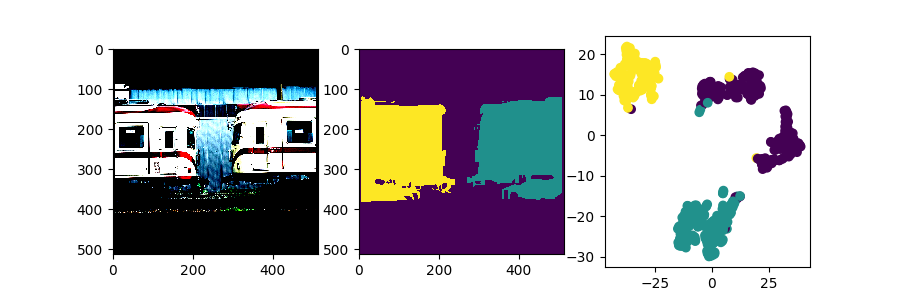

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [10]:
image, label = valset[1]
produce_tsne(net, image, label)

In [8]:
net = DeepLab_VGG_SpatialLate(n_classes=45)
d = torch.load("/srv/glusterfs/yardima/runs/deeplabv2/lfov-triplet/run_8/models/class-vgg-pascal_epoch-49.pth", map_location=lambda storage, loc: storage)
d['fc6.0.weight'] = torch.cat((d['fc6.0.weight'], net.state_dict()["fc6.0.weight"][:,-2:,:,:]), 1)
net.load_state_dict(d, strict=False)
net = net.eval().cuda()

In [9]:
import sklearn.manifold

def produce_tsne(net, image, label):
    label_original = label.data.numpy().copy()
    label_original[label_original==255] = 0
    image = image.unsqueeze(0)
    label = label.unsqueeze(0)
    
    fc8_interp_test = nn.UpsamplingBilinear2d(size=(label.shape[1], label.shape[2]))

    
    with torch.no_grad():
        image = image.cuda()
        out = net.forward(image)
        #embeddings = out.cpu().data.numpy()
        embeddings = fc8_interp_test(out).cpu()
        
    embeddings = np.transpose(embeddings.squeeze(), axes=[1, 2, 0]).reshape(-1, net.n_classes)
    labels = label.reshape(-1)
    
    embeddings = embeddings[labels != 255, :]
    labels = labels[labels != 255]

    
    ix = np.random.randint(low=0, high=embeddings.shape[0], size=(500,))
    embeddings_subset = embeddings[ix, :]
    labels_subset = labels[ix]
    
    X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(embeddings_subset)
    
    plt.figure(figsize=(9,3))

    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(image.squeeze(), axes=[1, 2, 0]))

    plt.subplot(1, 3, 2)
    plt.imshow(label_original.reshape(image.shape[2], image.shape[3]))

    plt.subplot(1, 3, 3)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels_subset)
    
    out = fc8_interp_test(out).data.cpu().numpy()